In [1]:
import collections
import gc
import itertools
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, Iterable, List, Set, Tuple

import numpy as np
import einops
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from core.monitor import Monitor
from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE, DTYPE
from dataset.construct import ImageDataset
from dataset.library import DATASETS


dataset_name, n_classes = DATASETS["Common"][1]
OUTPUT_DIR = "experiments/plots"
EXPERIMENT_DIR = "figures"
if not os.path.exists(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}"):
    os.makedirs(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}", exist_ok=True)
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Seed: 1149496617


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from modeling.vit_attention import OpenCLIPAttentionViT
from visualize.base import construct_per_layer_output_dict


# SECTION: Set up model
torch.set_default_device(DEVICE)
model = OpenCLIPAttentionViT({}, stop_layer=None).to(DEVICE)


# SECTION: Set up monitor
def mean_attention_matrix_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return torch.mean(einops.rearrange(
        tree_flatten(output_)[0][0],
        "b h n1 n2 -> b n1 n2 h"
    ), dim=-1).to(OUTPUT_DEVICE)


mask_layer = 9
detection_layer = 13
monitor_config = OrderedDict({
    f"model.visual.transformer.resblocks.{mask_layer - 1}": "cached_layer_output",
    f"model.visual.transformer.resblocks.{detection_layer}": OrderedDict({
        "": "layer_output",
        "attn": {
            "return_unmasked_attn_matrix": [
                ("unmasked_attention_matrix", mean_attention_matrix_hook_fn),
            ],
            "return_attn_matrix": [
                ("attention_matrix", mean_attention_matrix_hook_fn),
            ]
        }
    }),
})

monitor = Monitor(model, monitor_config)

# SECTION: Set up dataset
batch_size = 50
dataset = ImageDataset(dataset_name, split="train", return_original_image=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(DEVICE))
original_images, images = next(iter(dataloader))
# original_images, images = torch.flip(original_images, dims=[0]), torch.flip(images, dims=[0])


# SECTION: Run baseline model
per_metric_output_dict = monitor.reset()
with torch.no_grad():
    output = model.forward(images)

attention_matrix: torch.Tensor = per_metric_output_dict["unmasked_attention_matrix"][0]
layer_output: torch.Tensor = per_metric_output_dict["layer_output"][0]

In [3]:
%matplotlib inline
from dataclasses import dataclass
from core.attention_sink import mask_attention_sink
from modeling.image_features import ImageFeatures
from visualize.base import (
    VISUALIZED_INDICES,
    construct_per_layer_output_dict,
    visualize_features_per_image,
    visualize_feature_norms_per_image,
)
from visualize.attention import (
    visualize_attention_matrix_per_image,
    visualize_attention_suppression_per_image,
    visualize_incoming_attention_per_image,
)
from visualize.projections import (
    visualize_feature_values_by_pca,
)


@dataclass
class ModelLog:
    start: int = None
    end: int = None
    model: OpenCLIPAttentionViT = None
    mask_config: Dict[int, Tuple[OpenCLIPAttentionViT.ModeOptions, OpenCLIPAttentionViT.MaskOptions]] = None
    attn_out_proj_bias: bool = None
    monitor: Monitor = None
    per_metric_output_dict: OrderedDict[str, np.ndarray[List[torch.Tensor]]] = None


model_dict: Dict[str, ModelLog] = {
    # "test": ModelLog(start=detection_layer, end=test_layer),
    # "test": ModelLog(start=mask_layer, end=detection_layer, mask_config={
    #     i: (mode, mask_type) if i < continuation_layer else ("sink", "X -> X")
    #     for i in range(mask_layer, ImageFeatures.NUM_LAYERS)
    # }, attn_out_proj_bias=True),
    "Masking": ModelLog(start=mask_layer, end=detection_layer, mask_config={
        i: ("mask", "X -> T")
        for i in range(mask_layer, ImageFeatures.NUM_LAYERS)
    }, attn_out_proj_bias=True),
    "Type I": ModelLog(start=mask_layer, end=detection_layer, mask_config={
        i: ("sink", "X -> T")
        for i in range(mask_layer, ImageFeatures.NUM_LAYERS)
    }),
    # "Type II": ModelLog(start=mask_layer, end=detection_layer, mask_config={
    #     i: ("sink", "~{T} -> T")
    #     for i in range(mask_layer, ImageFeatures.NUM_LAYERS)
    # }),
    "Type II": ModelLog(start=mask_layer, end=detection_layer, mask_config={
        i: ("sink", "~T -> T")
        for i in range(mask_layer, ImageFeatures.NUM_LAYERS)
    }),
}


for k, log in model_dict.items():
    log.model = OpenCLIPAttentionViT(mask_config=log.mask_config, attn_out_proj_bias=log.attn_out_proj_bias, stop_layer=log.end + 1)
    log.monitor = Monitor(log.model, monitor_config)

cache: List[torch.Tensor] = [None] * (mask_layer - 1) + per_metric_output_dict["cached_layer_output"]
ranked_AS_mask: torch.Tensor = torch.full((batch_size, ImageFeatures.N + 1), torch.inf, device=OUTPUT_DEVICE)
# ranked_AS_mask: torch.Tensor = torch.load("experiments/saved_masks/ranked_AS_mask50.pt", map_location=OUTPUT_DEVICE)
with torch.no_grad():
    attention_dict: Dict[str, List[torch.Tensor]] = {k: [] for k in model_dict.keys()}
    layer_output_dict: Dict[str, List[torch.Tensor]] = {k: [] for k in model_dict.keys()}
    
    it, max_it = 1, float("inf")
    convergence = torch.full((batch_size,), False)
    while not torch.all(convergence) and it <= max_it:
        torch.set_default_device(DEVICE)
        for log in model_dict.values():
            log.per_metric_output_dict = log.monitor.reset()
            log.model.load_cache({"mask": ranked_AS_mask.isfinite(), "layer_output": cache})
            log.model.forward(images)
        torch.set_default_device(OUTPUT_DEVICE)

        for k, log in model_dict.items():
            attention_dict[k].append(log.per_metric_output_dict["unmasked_attention_matrix"][0])
            layer_output_dict[k].append(log.per_metric_output_dict["layer_output"][0])

        # SECTION: Massive token heuristic
        new_MA_mask = mask_attention_sink(model_dict["Masking"].per_metric_output_dict["attention_matrix"][0], max_num_tokens=1, masked_tokens=ranked_AS_mask.isfinite(), verbose=False)
            
        # SECTION: Update the cumulative MA mask with the new attention sinks
        ranked_AS_mask[new_MA_mask] = it
        it += 1
        
        # SECTION: Check convergence
        convergence = ~torch.any(new_MA_mask, dim=1)
        
        # SECTION: Cleanup
        for log in model_dict.values():
            log.per_metric_output_dict = None
            
        torch.cuda.empty_cache()
        gc.collect()

attentions: Dict[str, Dict[int, torch.Tensor]] = {k: torch.stack(v, dim=1) for k, v in attention_dict.items()}
layer_outputs: Dict[str, Dict[int, torch.Tensor]] = {k: torch.stack(v, dim=1) for k, v in layer_output_dict.items()}

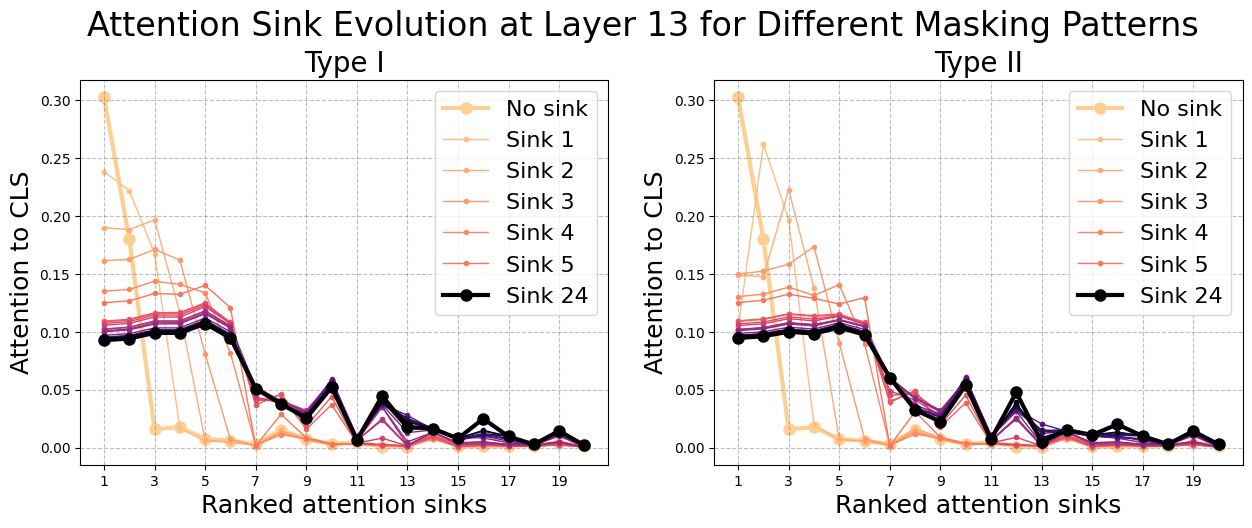

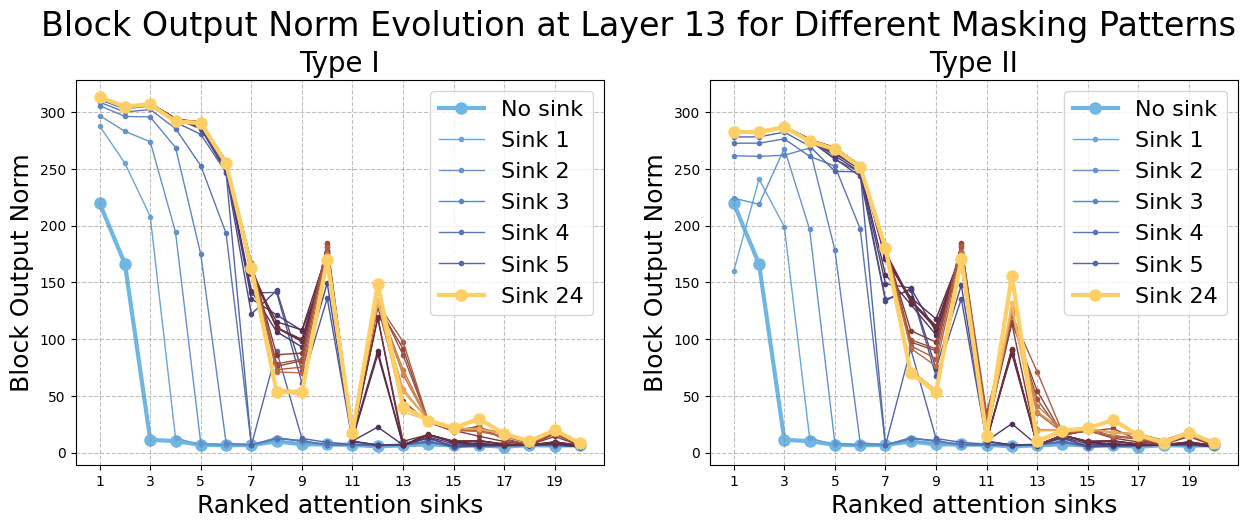

In [7]:
# SECTION: Compare attention sink type artifact tokens vs diagonal type artifact tokens
from visualize.base import visualize_features_per_image
from visualize.attention import visualize_attention_sink_decay_by_type, visualize_layer_output_decay_by_type


attentions, layer_outputs = attentions.copy(), layer_outputs.copy()
if "Masking" in attentions:
    del attentions["Masking"], layer_outputs["Masking"]
visualize_attention_sink_decay_by_type(
    attentions, ranked_AS_mask, {k: [*v.mask_config.values()][0][0] for k, v in model_dict.items()},
    f"Attention Sink Evolution at Layer {detection_layer} for Different Masking Patterns",
    use_cls_proxy=True, cmap="magma", save_dir=f"{OUTPUT_DIR}/{EXPERIMENT_DIR}",
)
visualize_layer_output_decay_by_type(
    layer_outputs, ranked_AS_mask, {k: [*v.mask_config.values()][0][0] for k, v in model_dict.items()},
    f"Block Output Norm Evolution at Layer {detection_layer} for Different Masking Patterns",
    use_cls_proxy=True, cmap="managua", save_dir=f"{OUTPUT_DIR}/{EXPERIMENT_DIR}",
)
# for k, attention_sequence in attentions.items():
#     mode, mask_type = [*model_dict[k].mask_config.values()]
#     visualize_attention_sink_decay(
#         attention_sequence, ranked_AS_mask, mode, f"Layer {detection_layer}: attention sink decay with {mode}ing top k ({mask_type})",
#         use_cls_proxy=True, lock_tokens=True
#     )

# diagonal_mask = artifact_mask * ~AS_mask
# # torch.save(diagonal_mask, f"{OUTPUT_DIR}/diagonal_mask.pt")
# print(torch.sum(AS_mask).item(), torch.sum(diagonal_mask).item())

# m = torch.full((batch_size, ImageFeatures.N + 1), False)
# m[-4, :] = True
# new_ranked_AS_mask = ranked_AS_mask * m

# visualize_features_per_image(features, 20, "layer_output", mta_mask=AS_mask, highlight=diagonal_mask)
# visualize_feature_values_by_pca(
#     features, 10, "layer_output", {"linear"}, new_ranked_AS_mask, rgb_assignment,
#     ndim=2,
#     with_cls=True,
#     highlight=diagonal_mask,
#     alpha=1.0,
# )